In [2]:
# import modules
import uproot, sys, time, random, argparse, copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from tqdm import tqdm
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
from collections import Counter
from scipy.stats import norm
from math import *

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 14.0,10.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 20.0 # Use 14 point font
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 13,
    "title": 13,
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],  # X and Y axis labels
    "xtick.labelsize": font_size["xticks"],  # X ticks
    "ytick.labelsize": font_size["yticks"],  # Y ticks
    "legend.fontsize": font_size["legend"]  # Legend
})

In [3]:

class Layer:
    def __init__(self,d,res_xy,res_z,position, ms=0):             
        self.d=d               #width in X0            
        self.res_xy=res_xy           #detector resolution     
        self.res_z=res_z
        self.ms=ms             #multiple scattering deviation
        self.position=position #position of the layer

def beta(p,m):
    '''beta function'''
    return p/sqrt(p*p+m*m)

def msresolution(l,p,m):
    '''calculate the multiscattering resolution'''
    if l.d==0:
        l.ms=0
    else:
        l.ms=0.0136/beta(p,m)/p*sqrt(l.d)*(1+0.038*log(l.d))

def eta2sintheta(eta):
    return (1/cosh(eta))

class Detector:   
    def __init__(self):
        self.layers=[]           #layers    position->Layer   
        self.layerpositions=[]        #layerpositions
        self.N=0                      #number of layers
        
    def addlayer(self, d,res_xy,res_z,position):
        '''Add a layer of detector'''
        if position in self.layerpositions:
            raise ValueError("Cannot add two layer at the same position")
        l=Layer(d,res_xy,res_z,position)
        self.layerpositions.append(position)
        self.layerpositions.sort()
        self.layers.insert(self.layerpositions.index(position),l)
        self.N+=1

    def addlayer2(self, l):
        position=l.position
        if position in self.layerpositions:
            raise ValueError("Cannot add two layer at the same position")
        self.layerpositions.append(position)
        self.layerpositions.sort()
        self.layers.insert(self.layerpositions.index(position),l)
        self.N+=1

    def track(self):
        a1=[1 for i in range(self.N)]
        a2=[self.layerpositions[i] for i in range(self.N)]
        a3=[self.layerpositions[i]*self.layerpositions[i]/2 for i in range(self.N)]
        return np.array((a1,a2,a3))

    def track_linear(self):
        a1=[1 for i in range(self.N)]
        a2=[self.layerpositions[i] for i in range(self.N)]
        return np.array((a1,a2))

    def covariancey_xy(self):
        t1=[]
        for i in range(self.N):
                t2=[]
                for j in range(self.N):
                        Cyij=0.0
                        if i==j:
                                Cyij+=self.layers[i].res_xy*self.layers[i].res_xy
                        for k in range(min([i,j])):
                                Cyij+=self.layers[k].ms*self.layers[k].ms*(self.layerpositions[i]-self.layerpositions[k])*(self.layerpositions[j]-self.layerpositions[k])
                        t2.append(Cyij)
                t1.append(t2)
        return np.array(t1)
    
    def covariancey_z(self):
        t1=[]
        for i in range(self.N):
                t2=[]
                for j in range(self.N):
                        Cyij=0.0
                        if i==j:
                                Cyij+=self.layers[i].res_z*self.layers[i].res_z
                        for k in range(min([i,j])):
                                Cyij+=self.layers[k].ms*self.layers[k].ms*(self.layerpositions[i]-self.layerpositions[k])*(self.layerpositions[j]-self.layerpositions[k])
                        t2.append(Cyij)
                t1.append(t2)
        return np.array(t1)

    def covariancey_z_1(self):
        covy=self.covariancey_z()
        return np.linalg.inv(covy)

    def covariancey_xy_1(self):
        covy=self.covariancey_xy()
        return np.linalg.inv(covy)
    
    def error_z(self):
        def covariancea():
            t=np.dot(self.track(),self.covariancey_z_1())
            t=np.dot(t,self.track().transpose())
            t=np.linalg.inv(t)
            return t       
        return covariancea()

    def error_xy(self):
        t=np.dot(self.track(),self.covariancey_xy_1())
        t=np.dot(t,self.track().transpose())
        t=np.linalg.inv(t)
        return t       
    
    def error_linear_z(self):
        t=np.dot(self.track_linear(),self.covariancey_z_1())
        t=np.dot(t,self.track_linear().transpose())
        t=np.linalg.inv(t)
        return t    

    def error_linear_xy(self):
        t=np.dot(self.track_linear(),self.covariancey_xy_1())
        t=np.dot(t,self.track_linear().transpose())
        t=np.linalg.inv(t)
        return t    
    
    def errorcalculation(self,p,B,eta=0,m=0.106):
        '''return the error
            p for p_T which is the transverse momentum'''
        error=dict()
        sintheta=eta2sintheta(eta)
        tempd=Detector()
        for i in range(self.N):
            l=copy.deepcopy(self.layers[i])
            l.d=l.d/sintheta
            l.position=l.position/sintheta
            msresolution(l,p/sintheta,m)
            tempd.addlayer2(l)
        ca=tempd.error_xy()
        ca_linear=tempd.error_linear_xy()
        error['sigma(pt)/pt']=sqrt(ca[2][2])*p/0.3/B*(1/sintheta)*(1/sintheta)
        #error['sigma(pt)/pt']=sqrt(ca[2][2])*p/(0.3*B)
        error['sigma(d)']=sqrt(ca[0][0])*1e6
        error['sigma(phi)']=sqrt(ca[1][1])/sintheta
        for i in range(self.N):
            tempd.layers[i].res_z=tempd.layers[i].res_z*sintheta
        ca=tempd.error_z()
        ca_linear=tempd.error_linear_z()
        error['sigma(z)']=sqrt(ca_linear[0][0])*1e6/sintheta
        error['sigma(theta)']=sqrt(ca_linear[1][1])
        return error

#examples of detectors
def ATLAS():
    Pixel1=Layer(0.0067,5.0e-5/sqrt(12),5.0e-5/sqrt(12),0.039)
    Pixel2=Layer(0.0067,5.0e-5/sqrt(12),5.0e-5/sqrt(12),0.099)
    Pixel3=Layer(0.0067,5.0e-5/sqrt(12),5.0e-5/sqrt(12),0.16)
    Pixel4=Layer(0.0067,5.0e-5/sqrt(12),5.0e-5/sqrt(12),0.22)
    Pixel5=Layer(0.0067,5.0e-5/sqrt(12),5.0e-5/sqrt(12),0.279)
    Strip1=Layer(0.02,7.575e-5/sqrt(12),7.575e-5/sqrt(12),0.405)
    Strip2=Layer(0.02,7.575e-5/sqrt(12),7.575e-5/sqrt(12),0.562)
    Strip3=Layer(0.02,7.575e-5/sqrt(12),7.575e-5/sqrt(12),0.762)
    Strip4=Layer(0.02,7.575e-5/sqrt(12),7.575e-5/sqrt(12),1)
    detector=Detector()
    detector.addlayer2(Pixel1)
    detector.addlayer2(Pixel2)
    detector.addlayer2(Pixel3)
    detector.addlayer2(Pixel4)
    detector.addlayer2(Pixel5)
    detector.addlayer2(Strip1)
    detector.addlayer2(Strip2)
    detector.addlayer2(Strip3)
    detector.addlayer2(Strip4)
    return detector

def Validation1():
    Pixel1=Layer(0,1e-6,1e-6,0.1)
    Pixel2=Layer(0,1e-6,1e-6,0.2)
    Pixel3=Layer(0,1e-6,1e-6,0.3)
    Pixel4=Layer(0,1e-6,1e-6,0.4)
    Pixel5=Layer(0,1e-6,1e-6,0.5)
    detector=Detector()
    detector.addlayer2(Pixel1)
    detector.addlayer2(Pixel2)
    detector.addlayer2(Pixel3)
    detector.addlayer2(Pixel4)
    detector.addlayer2(Pixel5)
    return detector

def Validation2():
    Pixel1=Layer(0.1,1e-8,1e-8,0.1)
    Pixel2=Layer(0.1,1e-8,1e-8,0.2)
    Pixel3=Layer(0.1,1e-8,1e-8,0.3)
    Pixel4=Layer(0.1,1e-8,1e-8,0.4)
    Pixel5=Layer(0.1,1e-8,1e-8,0.5)
    detector=Detector()
    detector.addlayer2(Pixel5)
    detector.addlayer2(Pixel4)
    detector.addlayer2(Pixel3)
    detector.addlayer2(Pixel2)
    detector.addlayer2(Pixel1)
    return detector

def inputfromfile(filename,verbose):
    if filename==None:return None
    userdetector=Detector()
    if verbose!=None:
        try:
            float(verbose)
            if float(verbose)>1:
                print("Error: verbose number must be either 1 or 0" %verbose)
                return None
        except:
            print("Error: Cannot resolve -verbose %s. It must be a number!" %verbose)
            return None
    try:
        f=open(filename, 'r')
        f.close()
    except:
        print("Error: Cannot open file from %s" %filename)
        return None
    with open(filename, 'r') as f: 
        if verbose:
            print("#\tWidth\tResolutionxy\tResolutionz\tposition")
        lines=f.readlines()
        count=0
        lines=[line for line in lines if len(line.split())==4 and line.split()[0][0]!='#']
        for line in lines:
            try:
                tempt=[float(num) for num in line.split()]
            except:
                print("Error: The input file is not supported, please check that the file is in required format.")
                return None
            count+=1
            d,resolutionxy,resolutionz,position=[float(num) for num in line.split()]
            userdetector.addlayer(d,resolutionxy,resolutionz,position)
            if verbose:
                print('%-3d\t%.5g\t%.5g\t\t%.5g\t\t%.5g'%(count,d,resolutionxy,resolutionz,position))
    if count==0:
        print("Error: The input file is not supported or empty, please check that the file is in required format.")
        return None
    print("Successfully read %d layers" %count)
    return userdetector

def addparser():
    parser = argparse.ArgumentParser(description='Detector resolution calculation.\nWritten by Feng Chen')
    parser.add_argument('-f', '--foo',help='input file at F00',default="CLD.txt")
    parser.add_argument('-m', '--m',help='mass of the particle in GeV/c^2 (default: muon mass)',default=0.106)
    parser.add_argument('-B', '--B',help='magnetic field in T (default: 2T)',default=2)
    parser.add_argument('-eta', '--eta',help='pseudorapidity (default: 0)',default=0)
    parser.add_argument('-p', '--p',help='momentum of the particle in GeV/c (default: 1 GeV)',default=1)
    parser.add_argument('-verbose', '--verbose',help='set to 1 to print the input layer configuration (default: 0)',default=0)
    args = parser.parse_args() 
    return [inputfromfile(args.foo,args.verbose), args.p,args.B,args.eta,args.m]

def calculation():
    detector,p,B,eta,m=addparser()
    if detector!=None:
        try:
            p=float(p)
        except:
            print("Error: Cannot resolve -p %s. It must be a number!" %p)
            return
        try:
            B=float(B)
        except:
            print("Error: Cannot resolve -B %s. It must be a number!" %B)
            return
        try:
            m=float(m)
        except:
            print("Error: Cannot resolve -m %s. It must be a number!" %m)
            return
        try:
            eta=float(eta)
        except:
            print("Error: Cannot resolve -eta %s. It must be a number!" %eta)
            return
        error=detector.errorcalculation(p,B,eta,m)
        for quantity in error.keys():
            print(quantity+'=%.4g'%error[quantity])
        return 1
    else:
        print('No detector is selected.')

def main():
    #print(Validation2().errorcalculation(1,2))
    print("load successfully")
    calculation()

if __name__ =="__main__":
    main()

    
 
# Plot is a function of the file input, the error variable (i.e. 'sigma(d)'), and the B field (default = 2T).

def plot(filename,var,B=2,eta=0,m=0.106):
    mydetector = inputfromfile(filename,1)
    p = np.logspace(1.0,1.0)
    y = []
    for i in range(len(p)):
        y.append(mydetector.errorcalculation(p[i],B,eta,m)[var])
    print(y[0])
    plt.xscale('log')
    plt.plot(p,y,label="Calculation")
    plt.legend
    return mydetector

load successfully
Error: The input file is not supported or empty, please check that the file is in required format.
No detector is selected.


In [7]:
file = uproot.open("/data/jlai/iris-hep/output/tracksummary_ckf.root")
tree = file["tracksummary"]
tree.keys()

arrays = tree.arrays([
    "t_d0", "eLOC0_fit", "res_eLOC0_fit",
    "t_z0", "eLOC1_fit", "res_eLOC1_fit",
    "t_phi", "ePHI_fit", "res_ePHI_fit",
    "t_theta", "eTHETA_fit", "res_eTHETA_fit",
    "t_p", "t_pT", "t_charge", "eQOP_fit", "res_eQOP_fit",
    "eT_fit", "t_time", "res_eT_fit", "t_theta"
], library="ak")

ak.flatten(arrays["t_pT"]) - ak.flatten(arrays["t_p"]) * np.sin(ak.flatten(arrays["t_theta"])) < 1e-6

<Array [True, True, True, True, ..., True, True, True, True] type='9203 * bool'>

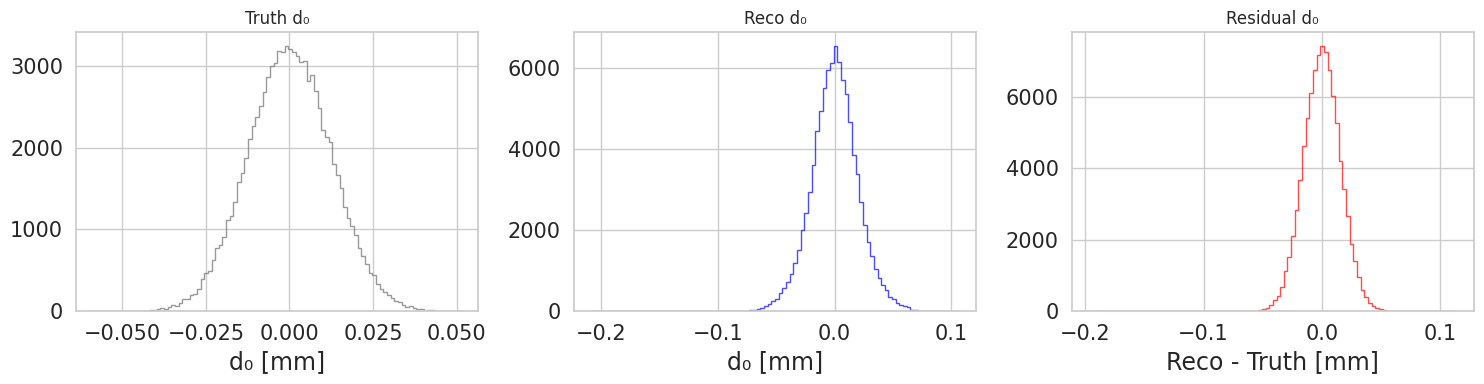

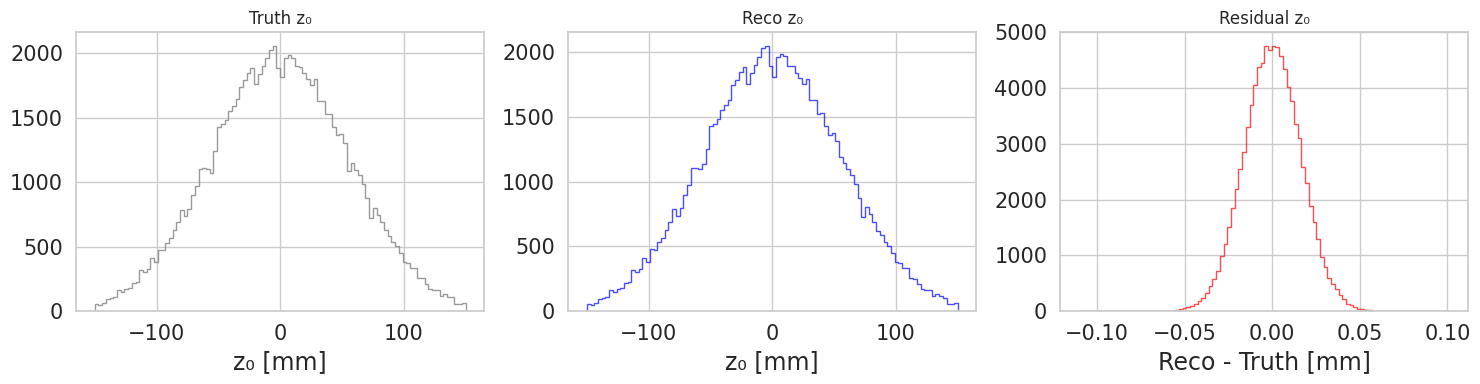

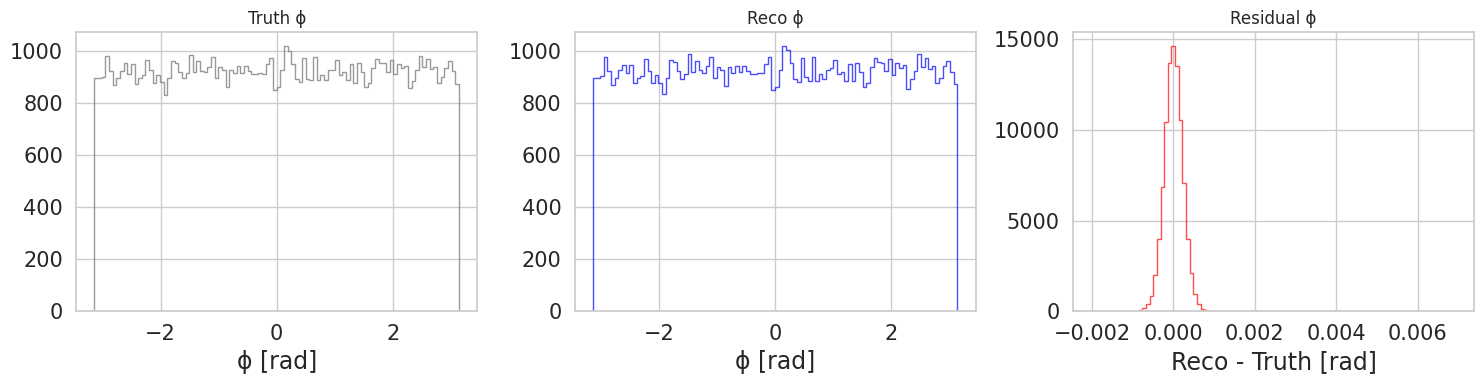

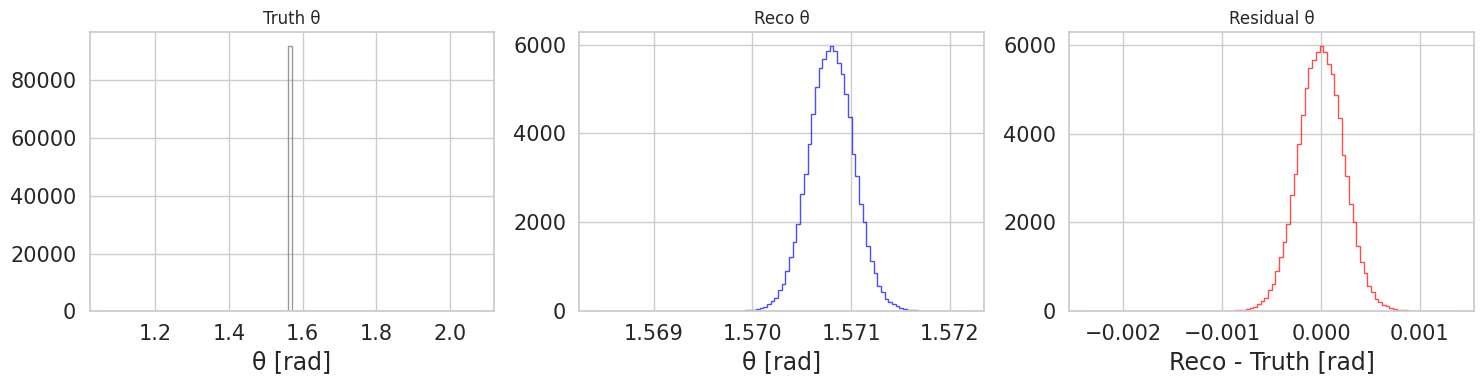

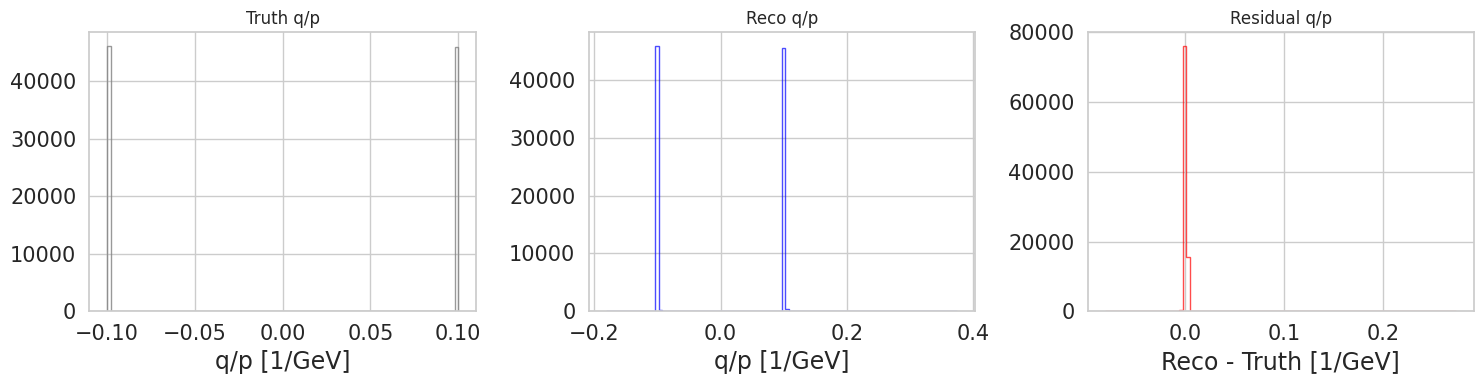

In [32]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt

# Load the file and tree
file = uproot.open("/data/jlai/iris-hep/output_100000/tracksummary_ckf.root")
tree = file["tracksummary"]

# Load relevant arrays
arrays = tree.arrays([
    "t_d0", "eLOC0_fit", "res_eLOC0_fit",
    "t_z0", "eLOC1_fit", "res_eLOC1_fit",
    "t_phi", "ePHI_fit", "res_ePHI_fit",
    "t_theta", "eTHETA_fit", "res_eTHETA_fit",
    "t_p", "eQOP_fit", "res_eQOP_fit",
    "t_charge"
])

# Plotting helper
def make_plot(truth, reco, resid, name, units=""):
    truth = ak.flatten(truth)
    reco = ak.flatten(reco)
    resid = ak.flatten(resid)

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    bins = 100

    axs[0].hist(truth, bins=bins, histtype='step', color='gray', alpha=0.8)
    axs[0].set_title(f"Truth {name}")
    axs[0].set_xlabel(f"{name} [{units}]")

    axs[1].hist(reco, bins=bins, histtype='step', color='blue', alpha=0.7)
    axs[1].set_title(f"Reco {name}")
    axs[1].set_xlabel(f"{name} [{units}]")

    axs[2].hist(resid, bins=bins, histtype='step', color='red', alpha=0.7)
    axs[2].set_title(f"Residual {name}")
    axs[2].set_xlabel(f"Reco - Truth [{units}]")

    plt.tight_layout()
    plt.show()

# Plot each
make_plot(arrays["t_d0"], arrays["eLOC0_fit"], arrays["res_eLOC0_fit"], "d₀", "mm")
make_plot(arrays["t_z0"], arrays["eLOC1_fit"], arrays["res_eLOC1_fit"], "z₀", "mm")
make_plot(arrays["t_phi"], arrays["ePHI_fit"], arrays["res_ePHI_fit"], "ϕ", "rad")
make_plot(arrays["t_theta"], arrays["eTHETA_fit"], arrays["res_eTHETA_fit"], "θ", "rad")

# Compute t_qop = q/p (charge over momentum)
t_pT = arrays
t_qop = arrays["t_charge"] / arrays["t_p"]
make_plot(t_qop, arrays["eQOP_fit"], arrays["res_eQOP_fit"], "q/p", "1/GeV")


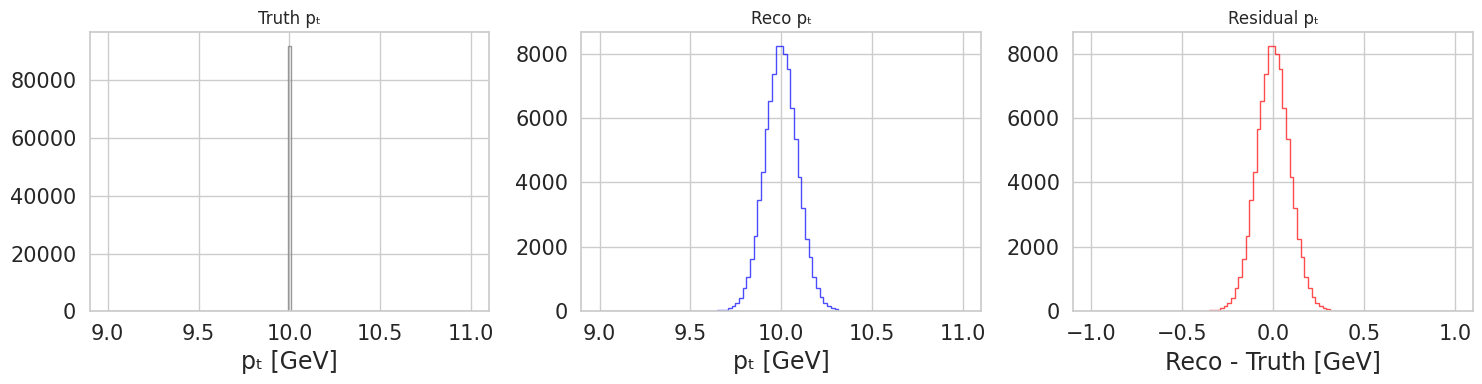

In [37]:
def make_plot(truth, reco, resid, name, units=""):
    # truth = ak.flatten(truth)
    # reco = ak.flatten(reco)
    # resid = ak.flatten(resid)

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    bins = np.linspace(9, 11, 100)

    axs[0].hist(truth, bins=bins, histtype='step', color='gray', alpha=0.8)
    axs[0].set_title(f"Truth {name}")
    axs[0].set_xlabel(f"{name} [{units}]")

    axs[1].hist(reco, bins=bins, histtype='step', color='blue', alpha=0.7)
    axs[1].set_title(f"Reco {name}")
    axs[1].set_xlabel(f"{name} [{units}]")

    bins = np.linspace(-1, 1, 100)

    axs[2].hist(resid, bins=bins, histtype='step', color='red', alpha=0.7)
    axs[2].set_title(f"Residual {name}")
    axs[2].set_xlabel(f"Reco - Truth [{units}]")

    plt.tight_layout()
    plt.show()

# Flatten needed arrays
theta = ak.flatten(arrays["t_theta"])
t_p = ak.flatten(arrays["t_p"])
eQOP = ak.flatten(arrays["eQOP_fit"])
q = ak.flatten(arrays["t_charge"])

# Compute pT truth
t_pT = t_p * np.sin(theta)

# Compute reco p from eQOP
p_reco = np.abs(1.0 / eQOP)  # assume q ≠ 0
pT_reco = p_reco * np.sin(theta)

# Compute residual
pT_resid = pT_reco - t_pT

# Plot
make_plot(t_pT, pT_reco, pT_resid, "pₜ", "GeV")


In [33]:
f = uproot.open("/data/jlai/iris-hep/acts/thirdparty/OpenDataDetector/data/odd-material-maps.root")
f.keys()

['SurfaceMaterial_vol2_bou0_lay2_app0_sen0;1',
 'SurfaceMaterial_vol2_bou0_lay2_app0_sen0/n;1',
 'SurfaceMaterial_vol2_bou0_lay2_app0_sen0/v;1',
 'SurfaceMaterial_vol2_bou0_lay2_app0_sen0/o;1',
 'SurfaceMaterial_vol2_bou0_lay2_app0_sen0/min;1',
 'SurfaceMaterial_vol2_bou0_lay2_app0_sen0/max;1',
 'SurfaceMaterial_vol2_bou0_lay2_app0_sen0/t;1',
 'SurfaceMaterial_vol2_bou0_lay2_app0_sen0/x0;1',
 'SurfaceMaterial_vol2_bou0_lay2_app0_sen0/l0;1',
 'SurfaceMaterial_vol2_bou0_lay2_app0_sen0/A;1',
 'SurfaceMaterial_vol2_bou0_lay2_app0_sen0/Z;1',
 'SurfaceMaterial_vol2_bou0_lay2_app0_sen0/rho;1',
 'SurfaceMaterial_vol16_bou0_lay2_app0_sen0;1',
 'SurfaceMaterial_vol16_bou0_lay2_app0_sen0/n;1',
 'SurfaceMaterial_vol16_bou0_lay2_app0_sen0/v;1',
 'SurfaceMaterial_vol16_bou0_lay2_app0_sen0/o;1',
 'SurfaceMaterial_vol16_bou0_lay2_app0_sen0/min;1',
 'SurfaceMaterial_vol16_bou0_lay2_app0_sen0/max;1',
 'SurfaceMaterial_vol16_bou0_lay2_app0_sen0/t;1',
 'SurfaceMaterial_vol16_bou0_lay2_app0_sen0/x0;1',
 'S

In [1]:
file = uproot.open("/data/jlai/iris-hep/output_100000/tracksummary_ckf.root")
tree = file["tracksummary"]


arrays = tree.arrays([
    "res_eLOC0_fit",
    "res_eLOC1_fit",
    "res_ePHI_fit",
    "res_eTHETA_fit",
    "res_eQOP_fit",
    "eQOP_fit",
    "t_p"
], library="ak")


pT = ak.flatten(tree["t_pT"].array())
t_p = ak.flatten(arrays["t_p"])
eQOP = ak.flatten(arrays["eQOP_fit"])
theta = ak.flatten(tree["t_theta"].array())

pT_truth = t_p * np.sin(theta)
pT_reco = np.abs(1.0 / eQOP) * np.sin(theta)
flat = {
    'res_eLOC0_fit': ak.flatten(tree["res_eLOC0_fit"].array()) * 1e3,
    'res_eLOC1_fit': ak.flatten(tree["res_eLOC1_fit"].array()) * 1e3,
    'res_ePHI_fit': ak.flatten(tree["res_ePHI_fit"].array()),
    'res_eTHETA_fit': ak.flatten(tree["res_eTHETA_fit"].array()),
    'res_pT_fit': (pT_reco - pT_truth)/pT_truth

    # 'res_p_fit': ( np.abs(1/ak.flatten(arrays["eQOP_fit"])) - ak.flatten(arrays["t_p"]) ) / ak.flatten(arrays["t_p"])
}

# flat = {field: ak.flatten(arrays[field]) for field in arrays.fields}

labels = {
    "res_eLOC0_fit": "d₀ residual (um)",
    "res_eLOC1_fit": "z₀ residual (um)",
    "res_ePHI_fit": "ϕ residual (rad)",
    "res_eTHETA_fit": "θ residual (rad)",
    "res_pT_fit": "pT residual"
}

# Store fit results
fit_results = {}

plt.figure(figsize=(30, 13))
for key, data in flat.items():
    data = data[~np.isnan(data)]  # Remove NaNs

    mu, sigma = norm.fit(data)
    fit_results[key] = sigma

    plt.subplot(231 + list(fit_results.keys()).index(key))
    counts, bins, _ = plt.hist(data, bins=100, histtype='step', linewidth=2, density=True, alpha=0.6, color='gray', label='Residuals')

    x = np.linspace(bins[0], bins[-1], 1000)
    plt.plot(x, norm.pdf(x, mu, sigma), 'r--', label=f'Gaussian Fit μ = {mu:.2e}, σ = {sigma:.2e}')

    plt.title(labels[key])
    plt.xlabel(labels[key])
    plt.ylabel("Frequency (normalized)", fontsize=12)
    plt.legend()
    plt.grid(True)
    # plt.tight_layout()
    # plt.show()

print("\nGaussian σ (resolution estimate) for each residual:")
for key, sigma in fit_results.items():
    print(f"{labels[key]:<25}: {sigma:.4e}")


NameError: name 'uproot' is not defined

In [43]:
for key, data in flat.items():
    data = data[~np.isnan(data)]
    mu, sigma = norm.fit(data)
    print(fit_results[key])

15.576811
16.294426
0.00023070228
0.00023139104
0.10291191


#	Width	Resolutionxy	Resolutionz	position
1  	0.00227	9999		9999		0.024
2  	0.00134	1.5e-05		1.5e-05		0.034
3  	0.00134	1.5e-05		1.5e-05		0.07
4  	0.00134	1.5e-05		1.5e-05		0.116
5  	0.00134	1.5e-05		1.5e-05		0.172
6  	0.00213	4.3e-05		0.0012		0.26
7  	0.00213	4.3e-05		0.0012		0.36
8  	0.00213	4.3e-05		0.0012		0.5
9  	0.00213	4.3e-05		0.0012		0.66
Successfully read 9 layers


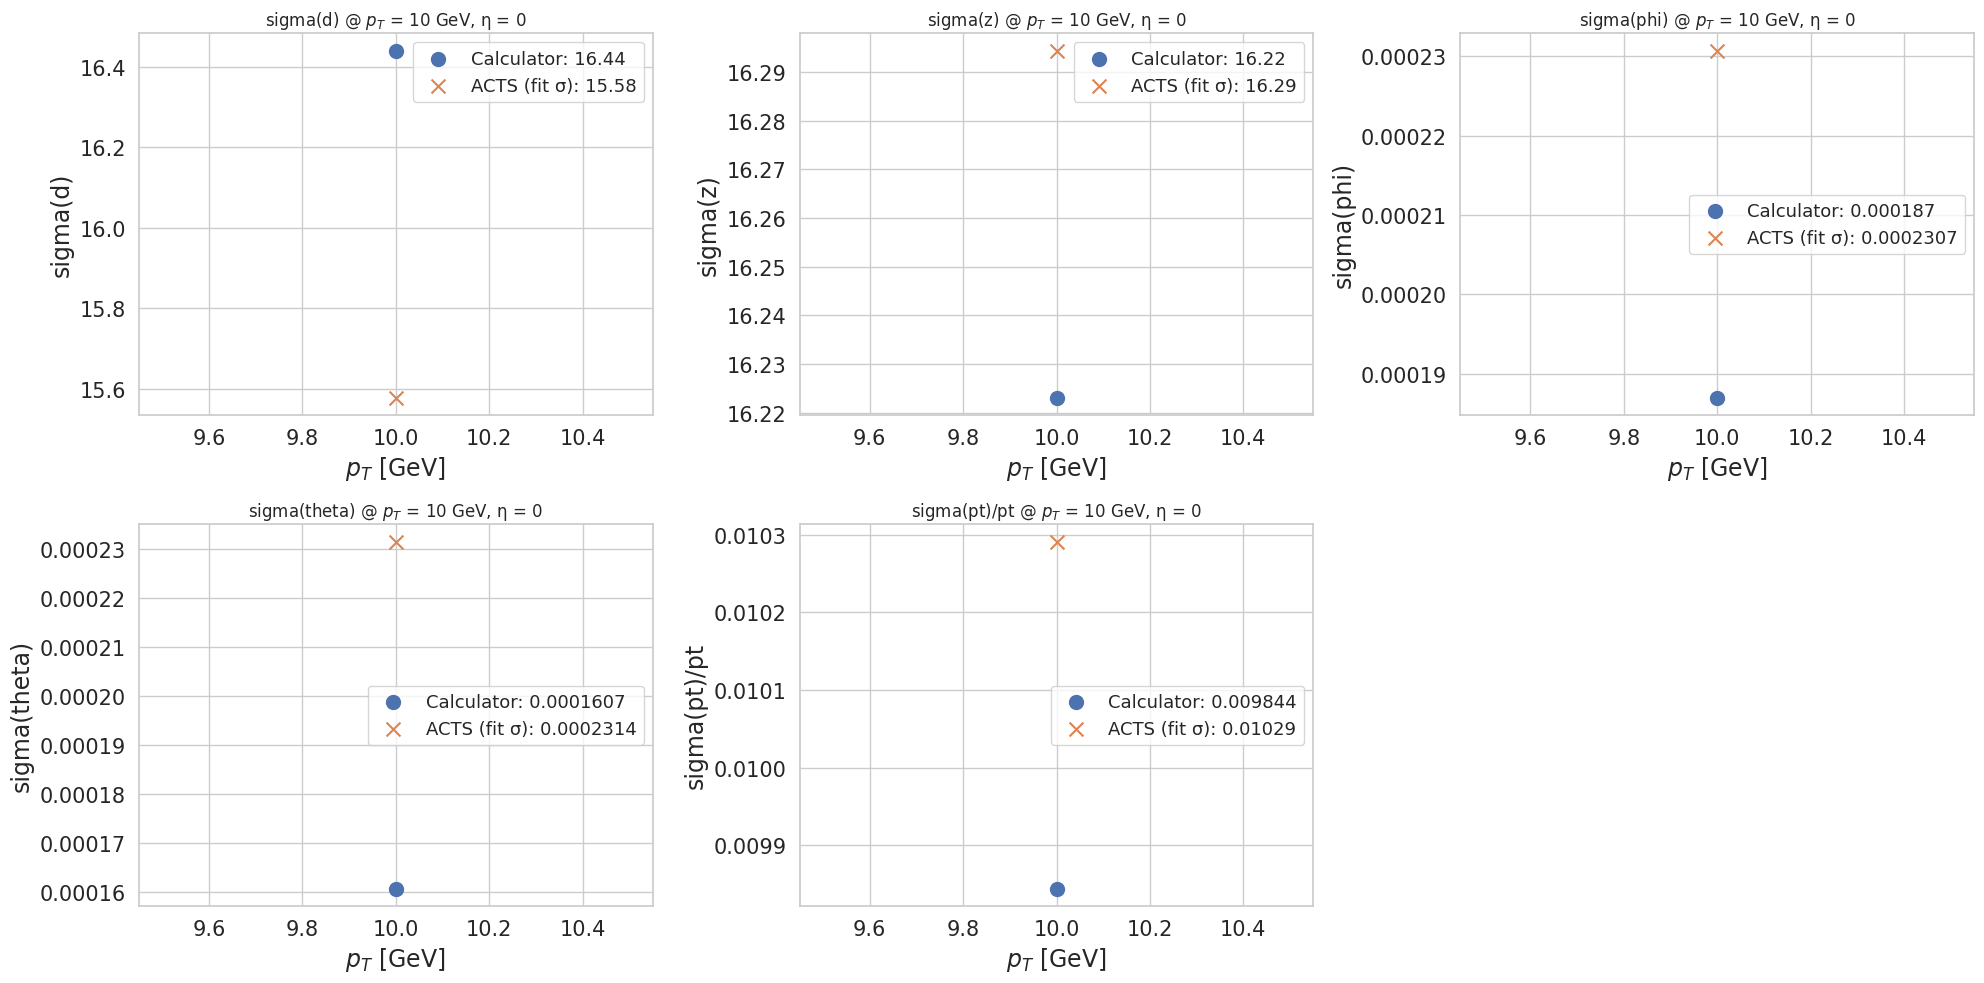

In [53]:
# Mapping for ACTS variable names to human-readable labels
var_map = {
    "res_eLOC0_fit": "sigma(d)",
    "res_eLOC1_fit": "sigma(z)",
    "res_ePHI_fit": "sigma(phi)",
    "res_eTHETA_fit": "sigma(theta)",
    "res_pT_fit": "sigma(pt)/pt"
}
inv_var_map = {v: k for k, v in var_map.items()}

# Load ACTS data and fit Gaussian to each residual
file = uproot.open("/data/jlai/iris-hep/output_100000/tracksummary_ckf.root")
tree = file["tracksummary"]

# arrays = tree.arrays(list(var_map.keys()), library="ak")
# flat = {field: ak.flatten(arrays[field]) for field in arrays.fields}

fit_results = {}
for key, data in flat.items():
    data = data[~np.isnan(data)]
    mu, sigma = norm.fit(data)
    fit_results[key] = sigma

# Load your detector model prediction
p, eta = 10, 0
B, m = 2, 0.106
mydetector = inputfromfile("myODD2.txt", 1)
calc_result = mydetector.errorcalculation(p, B, eta, m)

# Plot comparison
plt.figure(figsize=(20, 10))
for var_label in var_map.values():
    idx = list(var_map.values()).index(var_label)
    plt.subplot(2, 3, 1 + idx)

    key = inv_var_map[var_label]
    y_calc = calc_result[var_label]
    y_acts = fit_results[key]

    plt.scatter(p, y_calc, marker='o', s=100, label=f"Calculator: {y_calc:.4g}")
    plt.scatter(p, y_acts, marker='x', s=100, label=f"ACTS (fit σ): {y_acts:.4g}")
    plt.xlabel(r"$p_T$ [GeV]")
    plt.ylabel(var_label)
    plt.title(f"{var_label} @ $p_T$ = {p} GeV, η = {eta}")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()